# Preliminaries

In [1]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from pprint import pprint

In [2]:
THIS = 'dissipation-theory--Study-49--'
figs = {}

In [3]:
from dissipationtheory.constants import ureg, epsilon0, qe
from dissipationtheory.capacitance import Csphere
from dissipationtheory.dissipation8a import CantileverModel, SampleModel1, SampleModel2
from dissipationtheory.dissipation8b import CantileverModelJit, SampleModel1Jit, SampleModel2Jit
from dissipationtheory.dissipation8b import integrand1jit, integrand2jit
from dissipationtheory.dissipation8c import twodimCobject  # new!

# Capacitance of sphere over metal

Create a "metallic" Type I sample, choosing $z_{\mathrm{r}} = 50$ nm, in the middle of range of tip-sample separations we are interested in. 

In [4]:
cantilever = CantileverModel(
    f_c = ureg.Quantity(75, 'kHz'),
    k_c = ureg.Quantity(2.8, 'N/m'), 
    V_ts = ureg.Quantity(1, 'V'), 
    R = ureg.Quantity(30, 'nm'),
    angle = ureg.Quantity(20, 'degree'),
    L = ureg.Quantity(1000, 'nm'), 
    d = ureg.Quantity(38, 'nm')
)

sample1_metal = SampleModel1(
    cantilever = cantilever,
    h_s = ureg.Quantity(1e-6, 'nm'),  # not zero
    epsilon_s = ureg.Quantity(complex(1, 0), ''),
    sigma = ureg.Quantity(1e9, 'S/m'),
    rho = ureg.Quantity(1e26, '1/m^3'),
    epsilon_d = ureg.Quantity(complex(1e6, 0), ''),
    z_r = ureg.Quantity(50, 'nm')
)

sample1_jit_metal = SampleModel1Jit(**sample1_metal.args())

In [5]:
obj = {}

In [6]:
obj['A'] = twodimCobject(sample1_jit_metal, integrand1jit)

params = {'h': ureg.Quantity(15.0, 'nm'),
          'N': 15, # image charges
          'M': 30} # test points

obj['A'].addsphere(**params)

In [7]:
pd.DataFrame.from_dict(obj['A'].info, orient='index')

,0
type,sphere
r [nm],30.0
h [nm],15.0
N,15
M,30


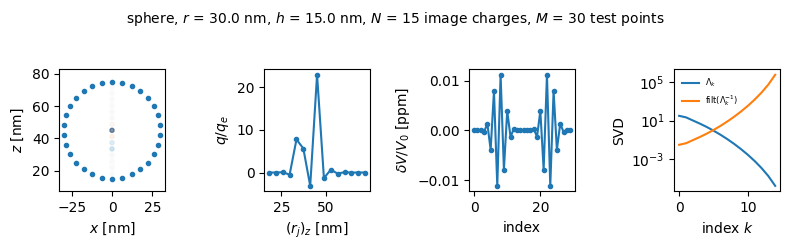

In [8]:
obj['A'].solve(0.)
figs['01'] = obj['A'].plot()

# Develop code for calculating properties

In [9]:
class twodimCobjectDev1(twodimCobject):

    def properties(self, printme=False):

        # Lambda values at 0 frequency and the cantilever frequency
        
        L0dc, L1dc, L2dc = self.solve(0.)
        L0ac, L1ac, L2ac = self.solve(self.sample.cantilever.omega_c)

        for key, val in zip(
            ['L0dc', 'L1dc', 'L2dc', 'L0ac', 'L1ac', 'L2ac'],
            [L0dc, L1dc, L2dc, L0ac, L1ac, L2ac]):

            self.results[key] = val

        # Capacitance and derivatives
        
        c0 = self.cGinv * (qe / self.Vr)
        C0 = (c0 / self.zr**0) * np.imag(complex(0,1) * L0dc) 
        C1 = (c0 / self.zr**1) * np.imag(complex(0,1) * L1dc) 
        C2 = (c0 / self.zr**2) * np.imag(complex(0,1) * L2dc)
        
        for key, values, unit in zip(
            ['C0 [aF]', 'C1 [pF/m]', 'C2 [mF/m^2]'],
            [C0, C1, C2],
            ['aF', 'pF/m', 'mF/m^2']):

            self.results[key] = values.to(unit).magnitude

        # Shorthand
        
        V0 = ureg.Quantity(self.sample.cantilever.V_ts, 'V')
        wc = ureg.Quantity(self.sample.cantilever.omega_c, 'Hz')
        fc = ureg.Quantity(self.sample.cantilever.f_c, 'Hz')
        kc = ureg.Quantity(self.sample.cantilever.k_c, 'N/m')
        
        # Other properties

        c1 = 2 * np.pi * epsilon0 * V0**2
        Fdc = c1 * np.imag(complex(0,1) * L1dc) 
        self.results['Fdc [pN]'] = Fdc.to('pN').magnitude

        c2 = (4 * np.pi * epsilon0 * V0**2) / (8 * wc * self.zr)
        gamma = c2 * np.real(complex(0,1) * L2ac)
        self.results['gamma [pN s/m]'] = gamma.to('pN s/m').magnitude

        c3 = (4 * np.pi * epsilon0 * V0**2) / (2 * self.zr)
        F11 =  1 * c3 * np.imag(complex(0,1) * L2dc)
        F12 = -1 * c3 * np.imag(complex(0,1) * L2ac)
        self.results['F1(1) [pN/nm]'] = F11.to('pN/nm').magnitude
        self.results['F1(2) [pN/nm]'] = F12.to('pN/nm').magnitude

        c4 = - fc / (2 * kc) 
        dfstat = c4 * F11
        self.results['Delta f stat [Hz]'] = dfstat.to('Hz').magnitude

        c5 = fc / (8 * kc)
        dfdyn = c5 * (F11 + F12)
        self.results['Delta f dyn [Hz]'] = dfdyn.to('Hz').magnitude
        
        self.results['Delta f [Hz]'] = (dfstat + dfdyn).to('Hz').magnitude

In [10]:
obj['B'] = twodimCobjectDev1(sample1_jit_metal, integrand1jit)

params = {'h': ureg.Quantity(15.0, 'nm'),
          'N': 15, # image charges
          'M': 30} # voltage test points

obj['B'].addsphere(**params)
pd.DataFrame.from_dict(obj['B'].info, orient='index')

,0
type,sphere
r [nm],30.0
h [nm],15.0
N,15
M,30


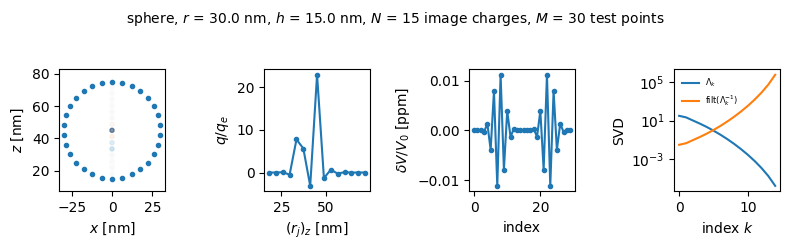

In [11]:
obj['B'].solve(0.)
figs['02'] = obj['B'].plot()

In [12]:
obj['B'].properties()
pd.DataFrame.from_dict(obj['B'].results, orient='index')

,0
alpha,0
q,"[0.00028358366711955796, -0.007278369492496495..."
S,"[31.283570034446335, 21.73319904250407, 10.362..."
Sinv,"[0.031965661172906425, 0.04601255425141412, 0...."
cn,17147523.648854
V,"[1.000000000007111, 1.00000000000279, 1.000000..."
Vrms [ppm],0.005214
L0dc,(0.9212212276926491+0j)
L1dc,(-0.6356309681425668+0j)
L2dc,(2.8012248949144714+0j)


# Develop code for sphere-plus-cone tip

In [13]:
class twodimCobjectDev2(twodimCobjectDev1):

    def addtip(self, h):
        """Model a cone-sphere tip above a ground plane.  The tip-sample
        separation is $h$.  The tip radius is $r$, the cone length is $L$,
        and the cone angle is $theta$ (read from self.sample.cantilever). 
        The $N_z$ image-charge points and the $N_r$ voltage test points 
        are placed following Xu and coworkers, Xu, J.; Li, J.; Li, W. 
        Calculating Electrostatic Interactions in Atomic Force Microscopy 
        with Semiconductor Samples. *AIP Advances* 2019, 9(10): 105308, 
        https://doi.org/10.1063/1.5110482."""
        
        # write h to sample.cantilever.object
        self.sample.cantilever.d = h.to('m').magnitude

        # convert h to nm and strip units
        h = h.to('nm').magnitude
        
        # read from sample.cantilever object
        r = ureg.Quantity(self.sample.cantilever.R, 'm').to('nm').magnitude  # unitless, nm
        L = ureg.Quantity(self.sample.cantilever.L, 'm').to('nm').magnitude  # unitless, nm
        theta = ureg.Quantity(self.sample.cantilever.angle, 'degree')        # keep units 
        
        # convert to radians 
        thetar = theta.to('radian').magnitude

        dz = r**2/(2 * (r + h))
        d2 = h + r * (1 - np.sin(thetar))
        
        Nt = 3
        Nc = int(np.floor(np.sqrt((L - r) / dz)))
        Nz = Nt + Nc
        
        rj = np.zeros((Nz, 3))
        rj[0,:] = np.array([0, 0, np.sqrt(2 * r * h + h**2)])
        rj[1,:] = np.array([0, 0, h + r - dz])
        rj[2,:] = np.array([0, 0, h + r])
        for k in np.arange(3, Nz):
            rj[k,0] = 0
            rj[k,1] = 0
            rj[k,2] = rj[k-1,2] + dz * (2 * k - 5)
        
        self.rj = rj

        Nr = Nz
        rk = np.zeros((Nr, 3))
        rk[0,:] = np.array([0, 0, h])
        rk[1,:] = np.array([r * np.sin((np.pi/2 - thetar)/2), 0, h + r * (1 - np.cos((np.pi/2 - thetar)/2))])
        rk[2,:] = np.array([r * np.cos(thetar), 0, h + r * (1 - np.sin(thetar))])
        for k in np.arange(3, Nz):
            rk[k,2] = (rj[k,2] + rj[k-1,2])/2
            rk[k,1] = 0
            rk[k,0] = r * np.cos(thetar) + (rk[k,2] - d2) * np.tan(thetar)

        self.rk = rk
        
        # save these
        self.info = {'type': 'sphere-tipped cone', 
                     'r [nm]': r, 
                     'h [nm]': h, 
                     'L [nm]': L, 
                     'theta [degree]': theta.to('degree').magnitude, 
                     'N': Nz,
                     'M': Nr}
        
        self.title1 = f'sphere-tipped cone, $r$ = {r:0.1f} nm, $h$ = {h:0.1f} nm, ' \
            f'$L$ = {L:0.1f} nm, $\\theta$ = {theta:0.1f}, $N_z$ = {Nz:d}, $N_r$ = {Nr:d}'
        self.title2 = ''
        
        # initialize the results, useful for plotting
        self.results = {
            'alpha': 0, 
            'q': np.ones(Nz),
            'S': np.ones(Nz),
            'Sinv': np.ones(Nz),
            'cn': 0, 
            'V': np.zeros(Nr)} 

In [14]:
obj['C'] = twodimCobjectDev2(sample1_jit_metal, integrand1jit)

params = {'h': ureg.Quantity(15.0, 'nm')}

obj['C'].addtip(**params)
pd.DataFrame.from_dict(obj['C'].info, orient='index')

,0
type,sphere-tipped cone
r [nm],30.0
h [nm],15.0
L [nm],1000.0
theta [degree],20.0
N,12
M,12


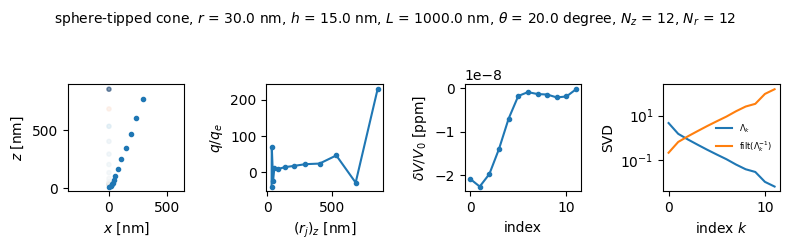

In [15]:
obj['C'].solve(0.)
figs['03']  = obj['C'].plot()

In [16]:
obj['C'].properties()
pd.DataFrame.from_dict(obj['C'].results, orient='index')

,0
alpha,0
q,"[-38.65718339453724, 70.8389788079644, -22.970..."
S,"[4.60258460177444, 1.5176998053899833, 0.85222..."
Sinv,"[0.21726922729773804, 0.6588918285741252, 1.17..."
cn,685.725673
V,"[1.0000000000000195, 1.0000000000000115, 0.999..."
Vrms [ppm],0.0
L0dc,(10.342984766989343+0j)
L1dc,(-1.2160549223150452+0j)
L2dc,(3.2104712977276075+0j)


::: {.content-hidden when-format="html"}

# Save the figures

In [17]:
if 1:
    for num in figs.keys():
        figname = THIS + "Fig-" + num
        figs[num].savefig(figname + '.png', dpi=300)
        figs[num].savefig(figname + '.pdf')

# Formatting notes

The header at the top of this file is for creating a nicely-formatted `.html` document using the program `quarto` ([link](https://quarto.org/)).  To create nicely-formated `.html`versions of this notebook, run `quarto` from the command line as follows

    quarto render dissipation-theory--Study-49.ipynb && open dissipation-theory--Study-49.html
    
:::